In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np

# visualize the osm objects within a chip

In [2]:
folder = '/opt/data/california-naip-chips/osm/'
files = os.listdir(folder)

file = np.random.choice(files)
z = gpd.read_parquet(f"{folder}/{file}")
z.explore()

## inspect and visualize the neighbours of a chip

In [3]:
folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours"
files = os.listdir(folder)
file = np.random.choice(files)
print(file)

z = pd.read_parquet(f"{folder}/{file}")
z

ca_m_3311806_sw_11_060_20220511-13-39.parquet


,chipid,lonm,latm,embeddings,distance
1399,ca_m_3311805_se_11_060_20220511-39-34,1.803510e+06,693380.489505,"[-0.15305443, 0.040456373, 0.12341575, -0.0075...",1977.773393
1439,ca_m_3311805_se_11_060_20220511-39-35,1.803509e+06,693226.862186,"[-0.13263912, 0.04782939, 0.13208027, -0.01736...",1916.597984
1479,ca_m_3311805_se_11_060_20220511-39-36,1.803508e+06,693073.234903,"[-0.14439575, 0.054718807, 0.123750575, -0.007...",1866.095761
1518,ca_m_3311805_se_11_060_20220511-38-37,1.803354e+06,692920.682765,"[-0.14120948, 0.047446232, 0.12588097, -0.0183...",1977.492502
1519,ca_m_3311805_se_11_060_20220511-39-37,1.803507e+06,692919.607657,"[-0.12899119, 0.043895837, 0.12502824, -0.0219...",1827.151947
...,...,...,...,...,...
254,ca_m_3311814_nw_11_060_20220511-14-6,1.805340e+06,690653.861507,"[-0.16536778, 0.038935788, 0.14808877, 0.01734...",1862.668965
255,ca_m_3311814_nw_11_060_20220511-15-6,1.805493e+06,690652.784853,"[-0.13718034, 0.040258314, 0.14210837, 0.00091...",1874.216091
256,ca_m_3311814_nw_11_060_20220511-16-6,1.805647e+06,690651.708165,"[-0.142465, 0.040013056, 0.12853767, -0.001118...",1898.167968
257,ca_m_3311814_nw_11_060_20220511-17-6,1.805801e+06,690650.631441,"[-0.13717596, 0.039467916, 0.12223117, -0.0060...",1934.063798


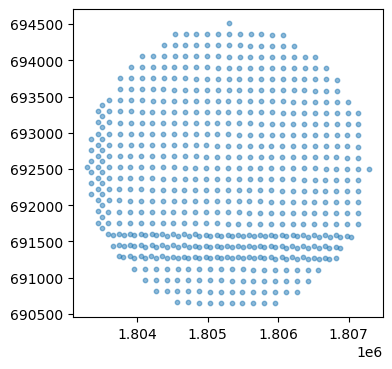

In [5]:
plt.figure(figsize=(4,4));
plt.scatter(z.lonm, z.latm, alpha=.5, s=10);

---
# Deduplicate the grid of neighbours

In [6]:
def grid_cell(df):
    '''Returns the cell of the geographical grid for each row in the dataframe.'''

    # Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).
    _center = df[df['distance'] == 0][['lonm', 'latm']].values[0]
    df[['lonm', 'latm']] -= _center
    X = df[['lonm', 'latm']].values  # coordinates

    # Compute distance matrix
    XXt = X@X.T
    L2 = np.diag(XXt)[:, None]  # vector of squared lengths
    D = np.sqrt(L2 + L2.T - 2*XXt)  # distance matrix
    D_triu = np.triu(D)

    # histogram of distances
    counts, bin_edges = np.histogram(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);
    i_bin = np.nonzero(counts > 500)[0][0]
    dist_nb = bin_edges[i_bin:i_bin + 2].mean()

    # dist_nb = 153.48
    bin_edges_square = np.arange(-13.5, 14.5, 1) * dist_nb
    ixbin = np.digitize(X[:,0], bin_edges_square) - 1
    iybin = np.digitize(X[:,1], bin_edges_square) - 1

    return list(zip(ixbin, iybin))

In [7]:
z['grid_cell'] = grid_cell(z)
z.sort_values('grid_cell', inplace=True)
z['uniform_norm'] = z['grid_cell'].map(lambda x: max(abs(x[0]-13), abs(x[1]-13)))
z.head()

,chipid,lonm,latm,embeddings,distance,grid_cell,uniform_norm
1718,ca_m_3311805_se_11_060_20220511-38-42,-1940.985338,-363.296398,"[-0.14880504, 0.032095883, 0.1359961, 0.005204...",1974.691965,"(0, 11)",13
1678,ca_m_3311805_se_11_060_20220511-38-41,-1939.909914,-209.669407,"[-0.15402731, 0.036686067, 0.12605695, -0.0012...",1951.207763,"(0, 12)",13
1560,ca_m_3311806_sw_11_060_20220511-0-39,-1997.157675,13.981507,"[-0.13400613, 0.033672214, 0.12959054, -0.0022...",1997.206614,"(0, 13)",13
1638,ca_m_3311805_se_11_060_20220511-38-40,-1938.834564,-56.042380,"[-0.13259335, 0.037016932, 0.12401662, -0.0020...",1939.644353,"(0, 13)",13
1598,ca_m_3311805_se_11_060_20220511-38-39,-1937.759288,97.584684,"[-0.16140689, 0.03581488, 0.13012725, 0.000467...",1940.214893,"(0, 14)",13


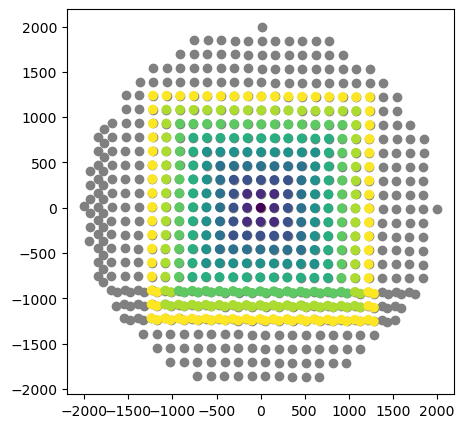

In [8]:
# With these new columns we can see overlapping chips and their grid-distance (uniform norm) from the center chip.

_z = z.query('uniform_norm <= 8').copy()  # slice chips within the square of radius 8

plt.figure(figsize=(5,5)); plt.scatter(z.lonm, z.latm, c='gray'); plt.scatter(_z.lonm, _z.latm, c=_z['uniform_norm']);

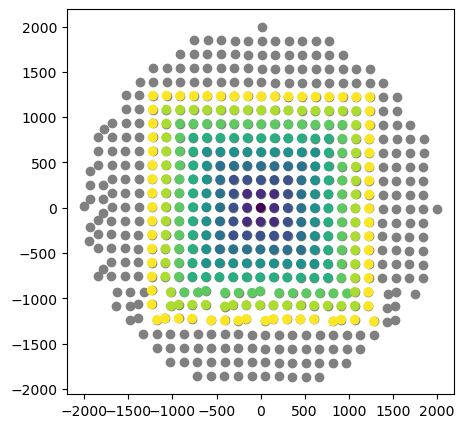

In [9]:
z_dedup = z.drop_duplicates(subset='grid_cell')

# Slice chips within the square of radius R
R = 8
_z = z_dedup.query(f'uniform_norm <= {R}').copy()
assert _z.shape[0] == (2*R + 1)**2

plt.figure(figsize=(5,5)); plt.scatter(z_dedup.lonm, z_dedup.latm, c='gray'); plt.scatter(_z.lonm, _z.latm, c=_z['uniform_norm']);

In [10]:
_z.head()

,chipid,lonm,latm,embeddings,distance,grid_cell,uniform_norm
86,ca_m_3311814_nw_11_060_20220511-6-2,-1174.142382,-1238.862081,"[-0.16136439, 0.036706813, 0.12621754, 0.00023...",1706.865428,"(5, 5)",8
1845,ca_m_3311806_sw_11_060_20220511-5-46,-1236.551516,-1066.786215,"[-0.14359424, 0.036905117, 0.11556089, 0.00275...",1633.123535,"(5, 6)",8
1805,ca_m_3311806_sw_11_060_20220511-5-45,-1235.475590,-913.159045,"[-0.15275776, 0.03411479, 0.11878306, -0.00769...",1536.313566,"(5, 7)",8
1765,ca_m_3311806_sw_11_060_20220511-5-44,-1234.399737,-759.531839,"[-0.14346014, 0.04596319, 0.119353235, -0.0092...",1449.355486,"(5, 8)",8
1725,ca_m_3311806_sw_11_060_20220511-5-43,-1233.323959,-605.904598,"[-0.15268114, 0.038645487, 0.1383637, 0.011416...",1374.120944,"(5, 9)",8


(289, 768) (17, 17, 768)


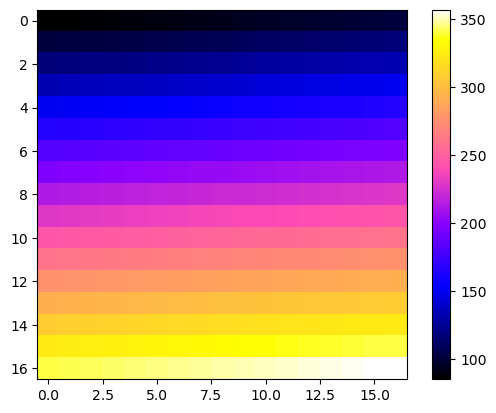

In [12]:
# Reshape this into a (2R+1)x(2R+1)x768 array, such that the (i,j) embedding is X[i,j,:]

E = np.stack(_z.embeddings.values)
# to remove
E[:,0] = _z['grid_cell'].map(lambda x: 16*x[0] + x[1])  # this is simply a colormarker for the placement of each embedding on the grid
X = E.reshape((17, 17, -1))

print(E.shape, X.shape)

plt.imshow(X[:,:,0], cmap='gnuplot2');  plt.colorbar();

---
 # Follow the steps 

In [13]:
# Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).

_center = z[z['distance'] == 0][['lonm', 'latm']].values[0]
z[['lonm', 'latm']] -= _center

n = z.shape[0]
X = z[['lonm', 'latm']].values  # coordinates
# distance matrix
XXt = X@X.T
L2 = np.diag(XXt)[:, None]  # vector of squared lengths
# _1_L2 = np.tile(L2, (n, 1))
# L2_1 = _1_L2.T
# D = np.sqrt(_1_L2 + L2_1 - 2*XXt)  # distance matrix
D = np.sqrt(L2 + L2.T - 2*XXt)  # distance matrix

D_triu = np.triu(D)

In [14]:
# histogram of distances
# counts, binedges, _ = plt.hist(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);
counts, binedges = np.histogram(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);

i_bin = np.nonzero(counts > 500)[0][0]
edges = binedges[i_bin:i_bin + 2]
dist_nb = edges.mean()
bin_edges = np.arange(-13.5, 14.5, 1) * dist_nb
print(edges)
print(dist_nb)

[153.15103488 153.97998436]
153.56550961874814


#### Histogram on the same edges

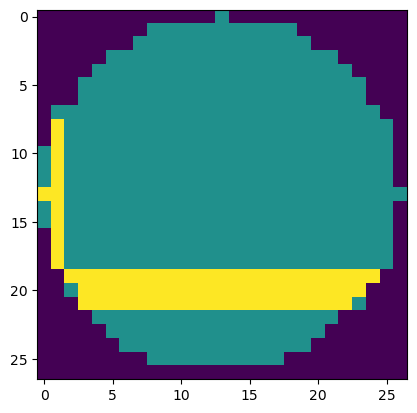

In [15]:
h, _xedges, _yedges = np.histogram2d(X[:,0], X[:,1], bins=(bin_edges, bin_edges));
plt.imshow(np.rot90(h));

In [16]:
ixbin = np.digitize(X[:,0], bin_edges) - 1
iybin = np.digitize(X[:,1], bin_edges) - 1
ibin = np.stack([ixbin, iybin], axis=1)  # grid indices of all chips
c = h[ixbin, iybin]

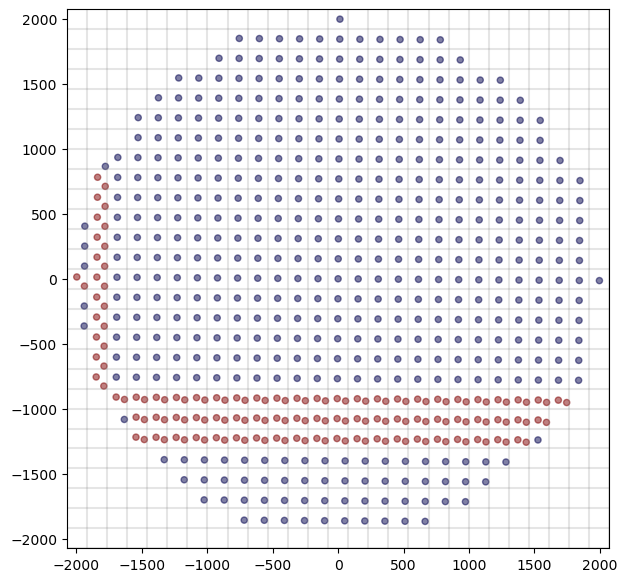

In [17]:
# Highlight grid-cells with more than one chip

plt.figure(figsize=(7,7));
plt.scatter(X[:,0], X[:,1], c=c, alpha=.5, s=20, cmap='seismic');
for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.2)
    plt.axhline(_edge, c='gray', alpha=.2)
plt.xlim(bin_edges.min(), bin_edges.max());
plt.ylim(bin_edges.min(), bin_edges.max());

In [18]:
# remove excess chips, from cells with high count (>1)

_, unique_indices, _ = np.unique(ibin, axis=0, return_index=True, return_counts=True)

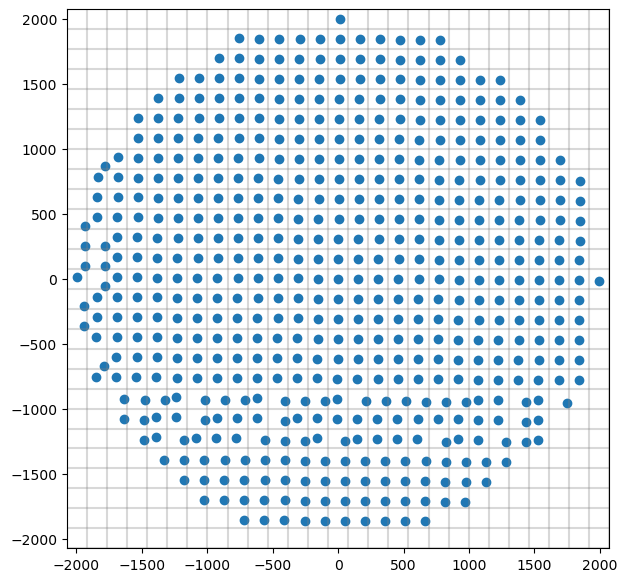

In [19]:
# De-duplicated neighborhood 

plt.figure(figsize=(7,7));
plt.scatter(X[unique_indices,0], X[unique_indices,1])#, alpha=.5, s=30, cmap='seismic');
for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.3)
    plt.axhline(_edge, c='gray', alpha=.3)
plt.xlim(bin_edges.min(), bin_edges.max());
plt.ylim(bin_edges.min(), bin_edges.max());

---

#### Is there a contiguous square grid around the center chip?

Is the square contiguous? -- True
chip width: 0.921 km
chip area: 0.849 sqkm


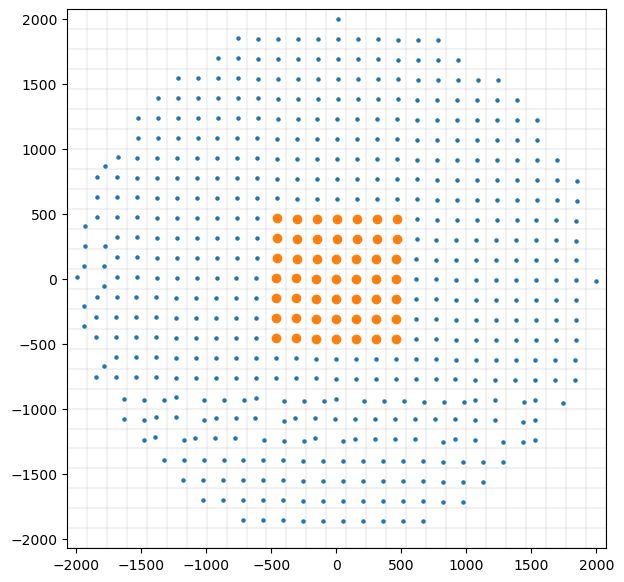

In [20]:
W = 7
_range = np.arange(-(W//2), (W//2) + 1)
indices_in_square = np.array([[13 + i, 13 + j] for i in _range for j in _range])

mask_unique_bins_in_square = np.isin(ibin[unique_indices], indices_in_square).all(axis=1)
mask_center_bin = (ibin == [13, 13]).all(axis=1)
# center_bin_coords = X[mask_center_bin][0]

print(f"Is the square contiguous? -- {h[*indices_in_square.T].all()}")
print(f"chip width: {dist_nb * (W-1) / 1000:.3f} km")
print(f"chip area: {(dist_nb * (W-1) / 1000)**2:.3f} sqkm")

plt.figure(figsize=(7, 7));
plt.scatter(*X[unique_indices].T, s=5);  plt.axis('square');
plt.scatter(*X[unique_indices][mask_unique_bins_in_square].T);

for _edge in bin_edges:
    plt.axvline(_edge, c='gray', alpha=.1); plt.axhline(_edge, c='gray', alpha=.1);
plt.xlim(bin_edges.min(), bin_edges.max()); plt.ylim(bin_edges.min(), bin_edges.max());

---

In [21]:
# Deduplicated slice of the original dataframe
z.iloc[unique_indices].head()

,chipid,lonm,latm,embeddings,distance,grid_cell,uniform_norm
1718,ca_m_3311805_se_11_060_20220511-38-42,-1940.985338,-363.296398,"[-0.14880504, 0.032095883, 0.1359961, 0.005204...",1974.691965,"(0, 11)",13
1678,ca_m_3311805_se_11_060_20220511-38-41,-1939.909914,-209.669407,"[-0.15402731, 0.036686067, 0.12605695, -0.0012...",1951.207763,"(0, 12)",13
1560,ca_m_3311806_sw_11_060_20220511-0-39,-1997.157675,13.981507,"[-0.13400613, 0.033672214, 0.12959054, -0.0022...",1997.206614,"(0, 13)",13
1598,ca_m_3311805_se_11_060_20220511-38-39,-1937.759288,97.584684,"[-0.16140689, 0.03581488, 0.13012725, 0.000467...",1940.214893,"(0, 14)",13
1558,ca_m_3311805_se_11_060_20220511-38-38,-1936.684087,251.211783,"[-0.13771068, 0.040238243, 0.12663725, 0.00020...",1952.908757,"(0, 15)",13


(49, 7)
(49, 768)


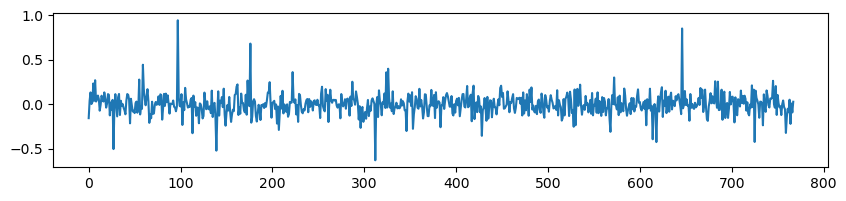

In [22]:
# Square-grid slice of the df
z_sq = z.iloc[unique_indices].iloc[mask_unique_bins_in_square]
print(z_sq.shape)

# Get the square grid neighborhood embeddings 

E = np.stack(z_sq['embeddings'].values)
print(E.shape)

plt.figure(figsize=(10,2));
plt.plot(E.mean(axis=0));

---
---
---
graveyard

In [29]:
# def deduplicate_neighbors(df):

#     # Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).
#     _center = df[df['distance'] == 0][['lonm', 'latm']].values[0]
#     df[['lonm', 'latm']] -= _center
#     X = df[['lonm', 'latm']].values  # coordinates

#     # Compute distance matrix
#     XXt = X@X.T
#     L2 = np.diag(XXt)  # vector of squared lengths
#     n = z.shape[0]
#     _1_L2 = np.tile(L2, (n, 1))
#     L2_1 = _1_L2.T
#     D = np.sqrt(_1_L2 + L2_1 - 2*XXt)  # distance matrix
#     D_triu = np.triu(D)

#     # histogram of distances
#     counts, bin_edges = np.histogram(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);
#     i_bin = np.nonzero(counts > 500)[0][0]
#     edges = bin_edges[i_bin:i_bin + 2]
#     dist_nb = edges.mean()

#     # dist_nb = 153.48
#     bin_edges_square = np.arange(-13.5, 14.5, 1) * dist_nb
   
#     ixbin = np.digitize(X[:,0], bin_edges_square) - 1
#     iybin = np.digitize(X[:,1], bin_edges_square) - 1
#     ibin = np.stack([ixbin, iybin], axis=1)  # grid indices of all chips

#     # remove excess chips, from cells with high count (>1)
#     _, unique_indices = np.unique(ibin, axis=0, return_index=True)

#     W = 7
#     _range = np.arange(-(W//2), (W//2) + 1)
#     indices_in_square = np.array([[13 + i, 13 + j] for i in _range for j in _range])
#     mask_unique_bins_in_square = np.isin(ibin[unique_indices], indices_in_square).all(axis=1)

#     return df.iloc[unique_indices], unique_indices, mask_unique_bins_in_square

In [77]:
# def square_neighborhood_df(df, W):
#     '''Returns a slice of the dataframe with the neighbors within a square of width W.'''
#     _r = np.arange(-(W//2), (W//2) + 1)
#     ix_in_square = [(13 + i, 13 + j) for i in _r for j in _r]
#     mask_in_square = df['grid_cell'].isin(ix_in_square)
#     return df[mask_in_square]